<a href="https://colab.research.google.com/github/codderrrrr/malaria_prediction/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPool2D,Conv2D,Dense, InputLayer, Flatten, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping

**Loading dataset**

In [4]:
dataset, info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files=True,split=['train'])

In [5]:
def split(dataset,train_ratio,val_ratio,test_ratio):
  size = len(dataset)

  train_data = dataset.take(int(train_ratio*size))

  val_test_data = dataset.skip(int(train_ratio*size))
  val_data = val_test_data.take(int(val_ratio*size))

  test_data = val_test_data.skip(int(val_ratio*size))
  return train_data,val_data,test_data

In [6]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
x_train,x_test,x_val = split(dataset[0],train_ratio,val_ratio,test_ratio)

**Data visuaization:**

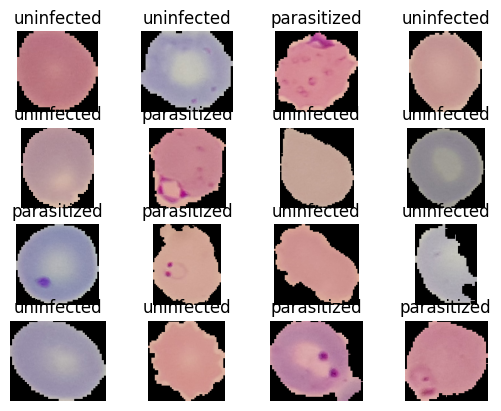

In [7]:
for i, (image,label) in enumerate(x_train.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(info.features['label'].int2str(label))
  plt.axis('off')

**Normalization:**

In [8]:
img_size = 224
def resize_and_rescale(image,label):
  return tf.image.resize(image,(img_size,img_size))/255.,label

In [9]:
x_train = x_train.map(resize_and_rescale)
x_test = x_test.map(resize_and_rescale)
x_val = x_val.map(resize_and_rescale)

In [10]:
x_train = x_train.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
x_val = x_val.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

**Model Build:**

In [11]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (img_size,img_size,3)),

    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=2),

    Flatten(),

    Dense(100,activation = 'relu'),
    Dropout(0.3),
    BatchNormalization(),

    Dense(10,activation = 'relu'),
    Dropout(0.3),
    BatchNormalization(),

    Dense(1,activation = 'sigmoid'),
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

**Model Training**

In [12]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = BinaryCrossentropy(), metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,)

In [14]:
maleria_pred_model = model.fit(x_train, validation_data=x_val, epochs = 50, verbose = 1, callbacks=[early_stopping])

Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 85s 106ms/step - accuracy: 0.5959 - loss: 0.7295 - val_accuracy: 0.6279 - val_loss: 0.6787
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.6895 - loss: 0.5896 - val_accuracy: 0.7925 - val_loss: 0.4617
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 103ms/step - accuracy: 0.8374 - loss: 0.3882 - val_accuracy: 0.9140 - val_loss: 0.2508
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 83s 120ms/step - accuracy: 0.8734 - loss: 0.3191 - val_accuracy: 0.5724 - val_loss: 2.7843
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 109s 72ms/step - accuracy: 0.8836 - loss: 0.3065 - val_accuracy: 0.9238 - val_loss: 0.2524
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/step - accuracy: 0.9060 - loss: 0.2605 - val_accuracy: 0.9318 - val_loss: 0.1960
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.9102 - loss: 0.2455 - val_accuracy: 0.8868 - val_loss: 0.3689
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 72s 70ms/step - accuracy: 0.9235 - loss: 0.216

**Model Evaluation**

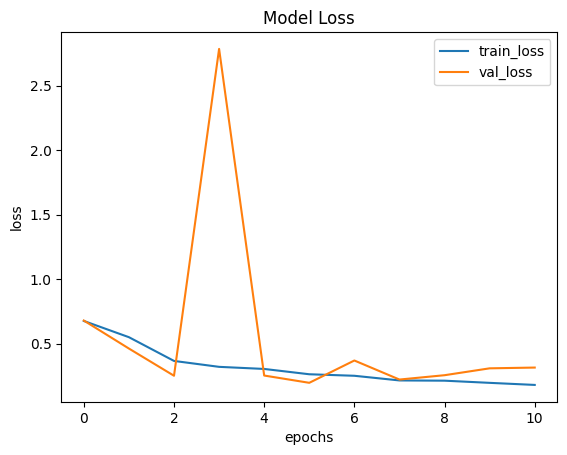

In [15]:
plt.plot(maleria_pred_model.history['loss'])
plt.plot(maleria_pred_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

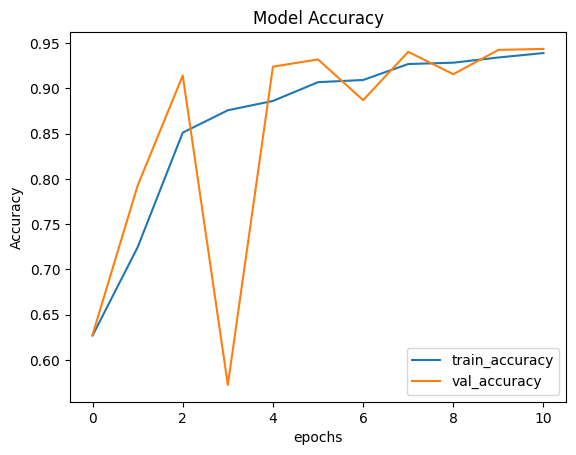

In [16]:
plt.plot(maleria_pred_model.history['accuracy'])
plt.plot(maleria_pred_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [17]:
x_test = x_test.batch(1)

**Model Prediction**

In [27]:
predictions = model.predict(x_test.take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [22]:
print(predictions[0][0])

0.8343009


In [23]:
def predict_malaria(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [25]:
print(predict_malaria((model.predict(x_test.take(1)))[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
U


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


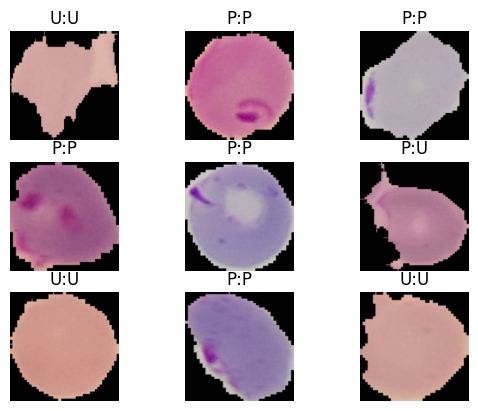

In [30]:
for i, (image, label) in enumerate(x_test.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(predict_malaria(label.numpy()[0]))+':'+(str(predict_malaria(model.predict(image))[0][0])))

  plt.axis('off')

**Saving model**

In [33]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [35]:
save_path = '/content/drive/MyDrive/Malaria_prediction_model.keras'
model.save(save_path)


In [37]:
import json

history_path = '/content/drive/MyDrive/Malaria_prediction_model.json'
with open(history_path, 'w') as f:
    json.dump(maleria_pred_model.history, f)
